In [97]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from CloudSaturation import CloudSaturation

# Configurator is awailable on
# https://apps.sentinel-hub.com/configurator/#/configurations
# username: koprivec.filip@gmail.com
# password: stefanpass

# If major edits are in order, just create new WMS instance (dont forget to update instanceid)


In [160]:
def plot_cloud_mask(mask, figsize=(15,15), cmap="gray", normalize=False, plot_cmap=False):
    """
    Utility function for plotting a binary cloud mask.
    """
    plt.figure(figsize=figsize)
    plot = plt.subplot(1, 1, 1)
    if not normalize:
        vmin_vmax = {"vmin":0, "vmax":1}
    else:
        vmin_vmax = dict()
    plot.imshow(mask, cmap=cmap, **vmin_vmax)
    # Todo: plot nice cmap

def plot_image(data, factor=1./255, cmap=None):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting 
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    rgb = data.astype(np.float32)
    if len(rgb.shape) == 3 and rgb.shape[2] == 3:
        rgb = rgb[..., [2, 1, 0]]
    plt.imshow(rgb * factor, cmap=cmap)
    

def plot_timeseries(data, factor=1./255, cmap="gray"):
    """
    Utility function for ploting timeseries type data.
    """
    
    
    return plot_image(np.array([data]), cmap=cmap)


def get_timeseries_delete(mask, true_c, bands, dates, cloud_masks, x_ind, y_ind, band_ind):
    # Filter images
    # Choose 0 band as reference for non photographed
    nonzero_image_indices = np.nonzero(bands[:,x_ind, y_ind, 0])
    nonzero_cloud_indices = np.nonzero(cloud_masks[:,x_ind, y_ind])
    both_nonzero = np.intersect1d(nonzero_image_indices, nonzero_cloud_indices)
    
    return bands[both_nonzero, x_ind, y_ind, band_ind], dates[both_nonzero]

def convert_to_dd(degms):
    deg, other = degms.split("°")
    minn, other = other.split("'")
    sec, way = other.split('"')
    
    return (float(deg) + float(minn)/60 + float(sec)/3600) * [-1,1][way=="N" or way=="E"]

def overlay_cloud_mask(image, mask=None, factor=1./255, nrows=1, ncols=1, figsize=(15, 15)):
    """
    Utility function for plotting RGB images with binary mask overlayed. The numpy arrays returned 
    by the Sentinel Hub's WMS and WCS requests have channels ordered as Blue (`B02`), Green (`B03`), 
    and Red (`B04`) therefore the order has to be reversed before ploting the image.
    """
    plt.subplots(nrows, ncols, figsize=figsize, frameon=False)
    rgb = np.zeros(image.shape, dtype=np.uint8)
    rgb = image[..., [2, 1, 0]]

    plt.imshow(rgb * factor)
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([255,255,0,100], dtype=np.uint8)
        plt.imshow(cloud_image)

In [197]:
# Requesting size of Slovenia BB results in error "The bounding box area is too large! Please zoom in."
tulip_box = [52.89906593845727, 4.71038818359375,52.95205098150524, 4.798278808593751]
home_box = [45.96916667, 14.31472222, 46.03416667, 14.35972222]
kocevje_box = [convert_to_dd("""45°34'52.69"N"""), convert_to_dd("""14°49'23.05"E"""),convert_to_dd("""45°36'34.31"N"""), convert_to_dd("""14°52'29.75"E""")]
#tulip_box = home_box
cloud_sat = CloudSaturation(tulip_box, cloud_scale=3)
kocevje_cloud = CloudSaturation(kocevje_box)
# This bounding box is also small enough so that all images are from the same tile -> no problems with cut-off

In [198]:
mask, true_c, bands, dates, cloud_masks = cloud_sat.get_cloud_saturation_mask()


Saved True color
Saved bands
Downloaded
(200, 199)
Detected
(115, 600, 597)
(115, 589, 589)
(589, 589, 3)


array([[0.59292035, 0.59292035, 0.59821429, ..., 0.69026549, 0.69026549,
        0.68141593],
       [0.61061947, 0.61061947, 0.61061947, ..., 0.70535714, 0.70535714,
        0.69026549],
       [0.61061947, 0.61061947, 0.61061947, ..., 0.70535714, 0.70535714,
        0.69642857],
       ...,
       [0.64285714, 0.64285714, 0.64285714, ..., 0.72321429, 0.72321429,
        0.70535714],
       [0.64285714, 0.64285714, 0.64285714, ..., 0.72321429, 0.72321429,
        0.70535714],
       [0.64285714, 0.64285714, 0.64285714, ..., 0.72321429, 0.71681416,
        0.70535714]])

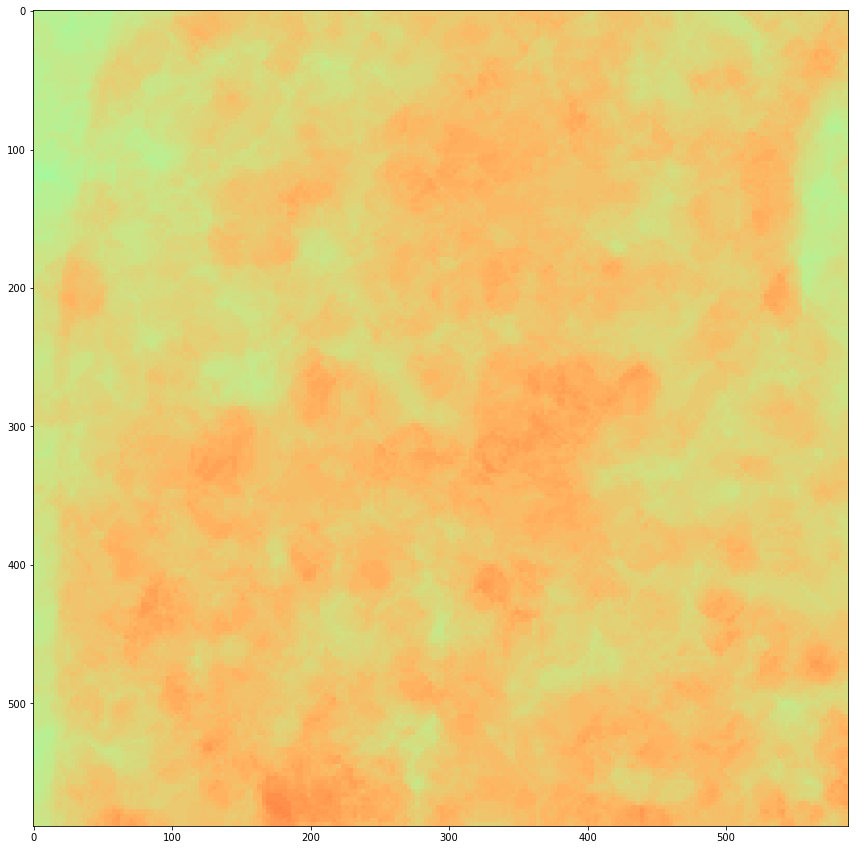

In [203]:
plot_cloud_mask(mask, cmap="rainbow", plot_cmap=True)
mask

In [195]:
# Collect sample indices (for the same area)
grayscale = cloud_sat.get_full_index_timeseries("MOISTURE-GRAYSCALE2")
ndvi = cloud_sat.get_full_index_timeseries("NDVI-GREEN-GRAYSCALE")

0.591304347826087


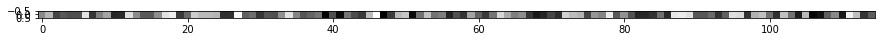

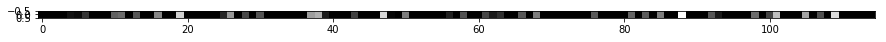

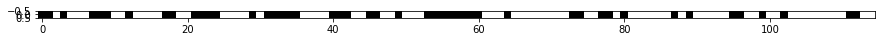

In [196]:
x_ind = 3
y_ind = 4
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="gray")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
ka[cf] = 1
# White are clouds
plot_timeseries(ka, cmap="gray")
print(len(cf[0])/len(ndvi))

0.6


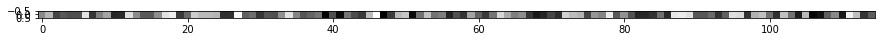

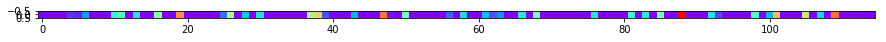

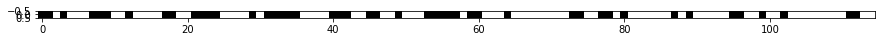

In [147]:
x_ind = 3
y_ind = 4
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="rainbow")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
ka[cf] = 1
# White are clouds
plot_timeseries(ka, cmap="gray")
print(len(cf[0])/len(ndvi))

In [115]:
# Dates of cloudy images
cloudy_dates = dates[cf]
cf

(array([  4,   5,   7,   8,   9,  12,  14,  15,  17,  18,  20,  22,  23,
         24,  25,  26,  30,  33,  34,  35,  36,  37,  39,  40,  41,  44,
         45,  47,  49,  53,  54,  56,  59,  66,  69,  70,  71,  73,  77,
         78,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  96,  97,  98,  99, 101, 103, 104, 105]),)

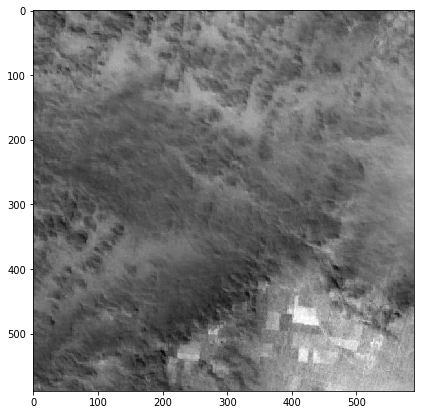

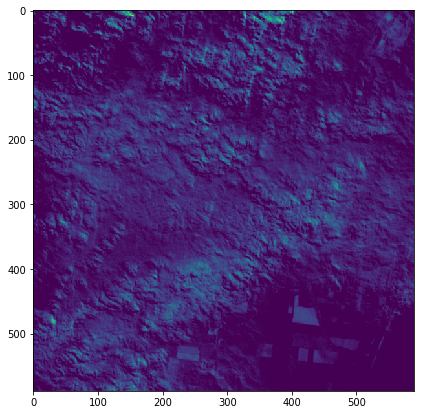

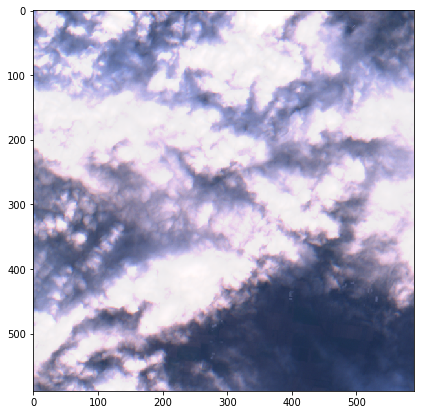

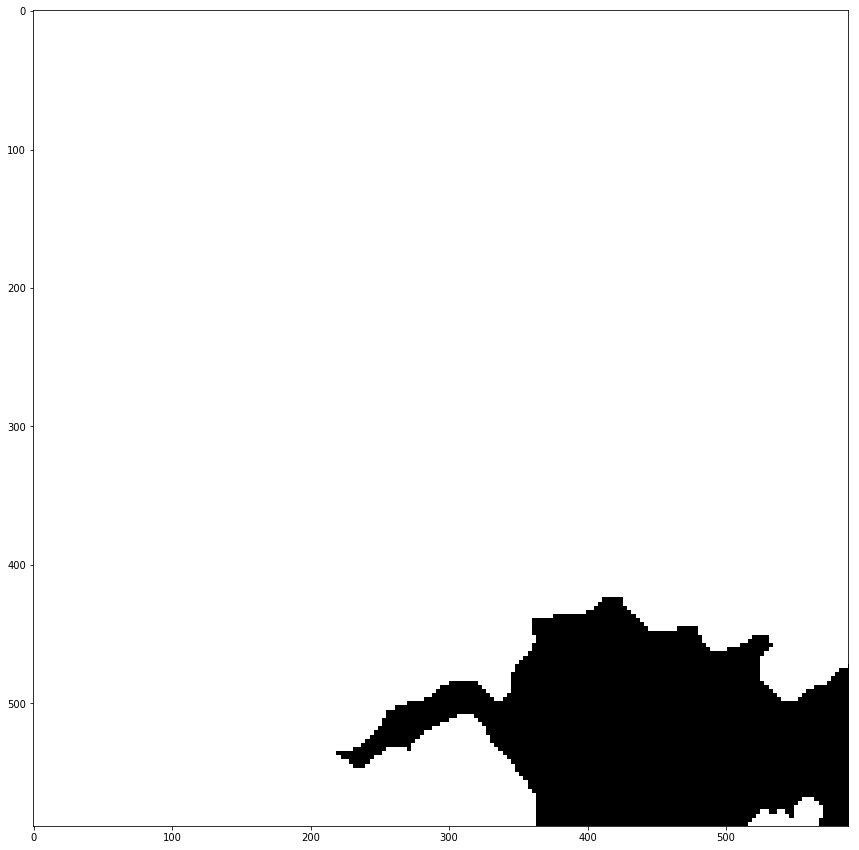

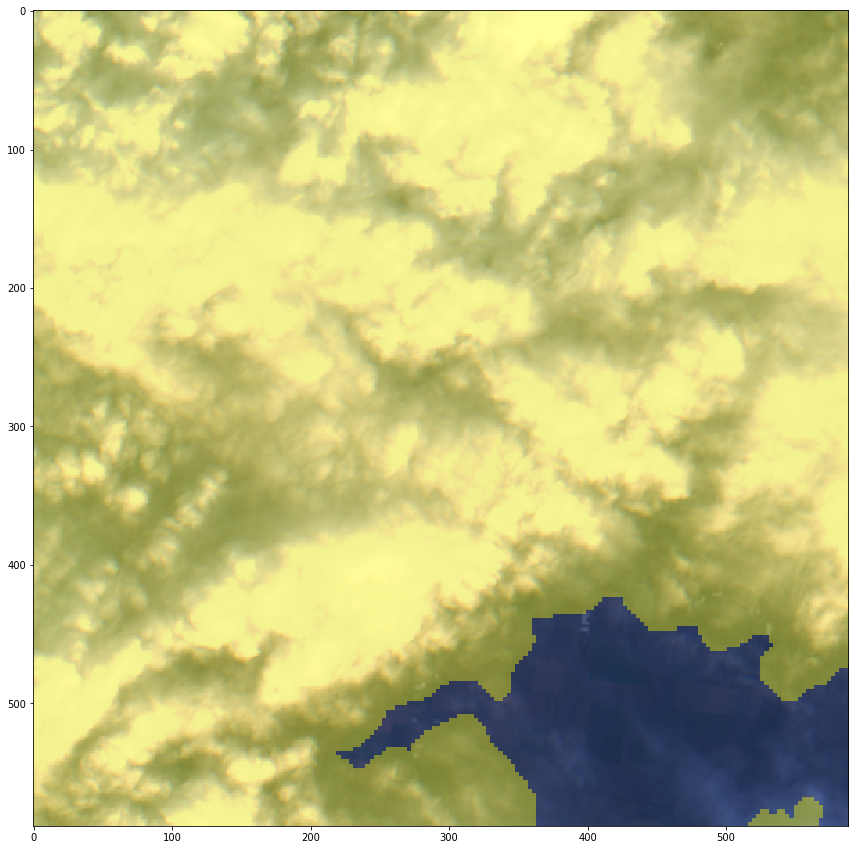

In [202]:
ind = 14
plot_image(grayscale[ind], cmap="gray")
plot_image(ndvi[ind])
plot_image(true_c[ind])
plot_cloud_mask(cloud_masks[ind])
overlay_cloud_mask(true_c[ind], cloud_masks[ind])

In [91]:
idd = "NDVI-GREEN-GRAYSCALE"
ndvi = cloud_sat.get_full_index_timeseries(idd)

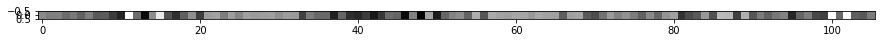

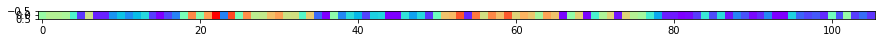

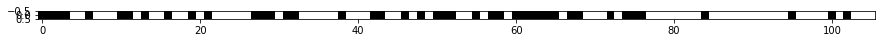

In [106]:
x_ind = 3
y_ind = 4
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="rainbow")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
ka[cf] = 1
# White are clouds
plot_timeseries(ka, cmap="gray")

In [107]:
grayscale[:,x_ind,y_ind].shape

(106,)

In [108]:
grayscale.shape

(106, 723, 348)

In [109]:
cf

(array([  4,   5,   7,   8,   9,  12,  14,  15,  17,  18,  20,  22,  23,
         24,  25,  26,  30,  33,  34,  35,  36,  37,  39,  40,  41,  44,
         45,  47,  49,  53,  54,  56,  59,  66,  69,  70,  71,  73,  77,
         78,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  96,  97,  98,  99, 101, 103, 104, 105]),)

In [124]:
maskk, true_ck, bandsk, datesk, cloud_masksk = kocevje_cloud.get_cloud_saturation_mask()
grayscale_kocevje = kocevje_cloud.get_full_index_timeseries("MOISTURE-GRAYSCALE2")
ndvi_kocevje = kocevje_cloud.get_full_index_timeseries("NDVI-GREEN-GRAYSCALE")

Saved True color
Saved bands
Downloaded
Detected
(212, 314, 404)
(314, 404, 3)


In [205]:
grayscale[:,x_ind,y_ind]
dates

array([datetime.datetime(2015, 7, 6, 10, 53, 51),
       datetime.datetime(2015, 7, 16, 10, 50, 24),
       datetime.datetime(2015, 7, 26, 10, 50, 24),
       datetime.datetime(2015, 8, 5, 10, 50, 26),
       datetime.datetime(2015, 8, 15, 10, 50, 41),
       datetime.datetime(2015, 8, 25, 10, 50, 41),
       datetime.datetime(2015, 9, 4, 10, 50, 42),
       datetime.datetime(2015, 9, 14, 10, 50, 44),
       datetime.datetime(2015, 9, 24, 10, 50, 44),
       datetime.datetime(2015, 11, 13, 10, 53, 1),
       datetime.datetime(2015, 12, 3, 10, 54, 20),
       datetime.datetime(2015, 12, 3, 10, 58, 18),
       datetime.datetime(2015, 12, 23, 10, 58, 43),
       datetime.datetime(2016, 1, 2, 11, 1, 29),
       datetime.datetime(2016, 1, 12, 10, 56, 21),
       datetime.datetime(2016, 1, 12, 11, 6, 48),
       datetime.datetime(2016, 2, 1, 10, 52, 53),
       datetime.datetime(2016, 2, 11, 10, 51, 55),
       datetime.datetime(2016, 3, 12, 10, 50, 37),
       datetime.datetime(2016, 3, 22,